# Joining information from different files to be analysed together.

In [1]:
%matplotlib inline

In [2]:
import os
import sys
import re
import pandas as pd
import nltk
import matplotlib.pylab as plt
from matplotlib.ticker import FuncFormatter

sys.path.insert(0, "./modules")
import bs_preprocess
import get_df_analise_section

# Configuration

In [3]:
data_path = 'data'

#ds_name = 'DOI_cited_science_1179052_retracted'
%store -r ds_name
ds_label = ds_name

analysis_path = os.path.join(data_path, 'analysis')

# In
citing_tsv = os.path.join(analysis_path, '%s.tsv' % ds_name)
citing_prep_tsv = os.path.join(analysis_path, '%s_prep.tsv' % ds_name)

# Out
citing_sections_tsv = os.path.join(analysis_path, '%s_sections.tsv' % ds_name)
analysis_hist_tsv = os.path.join(analysis_path, '%s_hist.tsv' % ds_name)

In [4]:
figures_path = 'figures'

%store -r ds_name
%store -r DOI_cited_list_number 
ds_label = ds_name


#figures_path = os.path.join(figures_path, 'analysis')
os.makedirs(figures_path, exist_ok=True)


# Recording figures
figure_citation_full_list = os.path.join(figures_path, '%s_.jpg' % ds_name)
figure_citation_1DOI  = os.path.join(figures_path, '%s_DOI_position_%s.jpg' % (ds_name, DOI_cited_list_number))                                    

# Setup

In [5]:
# One time download required
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/sherlock/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# 1.- ANALYSIS

•	Analyse file containing papers citing a particular DOI. This DOI can be read from a file (the one used in get_papers) or directly introduced in a list.
•	By calling get_df_analise_section it generates a dataframe containing:
    
    # df['cited_DOI', 'citing_DOI', 'reference_id', 'introduction_found', 
    #   'cited_in_introduction', 'maintext_found', 'cited_in_maintext', 
    #   'discussion_found', 'cited_in_discussion', 'conclusions_found', 
    #   'cited_in_conclusions', 'sentence_citing_intro', 
    #   'sentence_citing_maintext', 'sentence_citing_discussion', 
    #   'sentence_citing_conclusions']
    
-	reference_id is the number of reference of the cited paper in a particular paper. 
-	'introduction_found', 'maintext_found', 'discussion_found' and 'conclusions_found' get True/False value depending on whether a particular section has been found.
-	'cited_in_introduction', 'cited_in_maintext', 'cited_in_discussion', 'cited_in_conclusions' get True/False values depending on whether the paper is cited in these sections.
-	'sentence_citing_intro',  'sentence_citing_maintext', 'sentence_citing_discussion',    'sentence_citing_conclusions' are the sentences in each section where the paper is cited.


•	It also generates another dataframe with information about how many times the paper has been cited in each section: 

     # dict_citation_hist ['DOI_cited', 'total_papers_citing', 'papers_all_sections_found',  
     #   'cited_in_introduction', 'cited_in_maintext', 'cited_in_discussion', 'cited_in_conlusions']

•	It saves the dataframes in two files. 
Note: For “df” only the information of the last paper (cited_DOI) analysed is saved 




In [6]:
list_df_analysis = []
list_citation_hist = []

#DOI_list = ["10.1126/science.1179052"]
%store -r DOI_list

df_articles = pd.read_csv(citing_prep_tsv, sep='\t', encoding='utf-8')


for index, DOI in enumerate(DOI_list): 

    df_articles_citingDOI = df_articles[df_articles['DOI_cited'] == DOI]['article_citing']
    list_articles_citingDOI = df_articles_citingDOI.values.tolist()

    df = get_df_analise_section.get_df(DOI, list_articles_citingDOI)


    total_papers = df.shape[0]
    # mask1: sections found
    #mask1 = (df['introduction_found'] == True) | ((df['discussion_found'] == True) | (df['conclusions_found'] == True))  

    # mask2: the reference is found at least in one section
    mask2 = (df['cited_in_introduction'] == True) | (df['cited_in_maintext'] == True) | (df['conclusions_found'] == True) | df['sentence_citing_conclusions'] == True
     
    mask = mask2 
    print("\nindex in list: " + str(index) + "\t DOI: " + str(DOI) )
    papers_all_sections_found = df[mask].shape[0]    
    print("Number of papers found citing the DOI:  ", papers_all_sections_found)
    print("(Taking into account only those in which the code has found a particular section citing)")

    found_in_percentages = (df[mask].select_dtypes(include=['bool']).sum() / papers_all_sections_found).to_dict()

    list_citation_hist.append({
        'DOI_cited': DOI,  
       'total_papers_citing': total_papers,
       'papers_all_sections_found': papers_all_sections_found,
        **{
            k: found_in_percentages.get(k, 0)
            for k in {'cited_in_introduction', 'cited_in_maintext', 'cited_in_discussion', 'cited_in_conclusions'}
        }
    })

pd_citation_hist = pd.DataFrame(list_citation_hist) 


############### SAVING IN FILES #####################
df.to_csv(citing_sections_tsv, index=False, sep='\t', encoding='utf-8')
print('Wrote to:', citing_sections_tsv)

pd_citation_hist.to_csv(analysis_hist_tsv, index=False, sep='\t', encoding='utf-8')
print('Wrote to:', analysis_hist_tsv)


 Numer of papers found citing the DOI:   0
(Disregarding those where the code has not been able to found at least one particular section citing)

 Numer of papers found citing the DOI:   0
(Disregarding those where the code has not been able to found at least one particular section citing)

 Numer of papers found citing the DOI:   1
(Disregarding those where the code has not been able to found at least one particular section citing)

 Numer of papers found citing the DOI:   29
(Disregarding those where the code has not been able to found at least one particular section citing)
Wrote to: data/analysis/DOI_cited_1000times_papers_citing_sections.tsv
Wrote to: data/analysis/DOI_cited_1000times_papers_citing_hist.tsv


In [7]:
df_articles.head(5)

,DOI_cited,article_citing
0,10.1093/0198742002.001.0001,"<html><body><article article-type=""research-ar..."
1,10.1016/0003-2697(89)90602-7,<html><body><sub><italic>m</italic></sub>value...
2,10.1016/0003-2697(89)90602-7,<p>3_Biotech/PMC5106402.nxml ...
3,10.1016/0003-2697(89)90602-7,<p>Acta_Neuropathol_Commun/PMC4029267.nxml ...
4,10.1016/0003-2697(89)90602-7,<p>Anal_Bioanal_Chem/PMC4819935.nxml ...


# 2.- PLOT

•	Plot the analysis (file_df_analysis_hist). 
-	For multiple papers (used to plot the analysis of papers having the same number of citations)
-	Just for one.



 DOIs with the required minimum number of citations found of 1: 



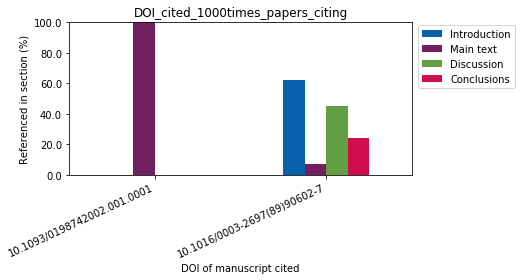

In [8]:
%store -r minimun_number_citations
%store -r DOI_list



DOI_list_filtered = df_articles.groupby('DOI_cited').size().pipe(
    lambda df: df[df >= minimun_number_citations]
).index.values
print('\n DOIs with the required minimum number of citations found of %d: \n' % minimun_number_citations) #, DOI_list_filtered))

"""
if len(DOI_list_filtered) != 0:
    print("Index\t DOI")
    for index, DOI_in_list_filtered in enumerate(DOI_list):
        print(str(index) + '\t' + str(DOI_in_list_filtered))  
"""    
    
# Reading the pd_citation_hist from file:
pd_citation_hist = pd.read_csv(
    analysis_hist_tsv,
    sep='\t',
    encoding='utf-8'
)


pd_citation_hist_filtered = pd_citation_hist[pd_citation_hist.DOI_cited.isin(DOI_list_filtered)]

if pd_citation_hist_filtered.empty == False:
    
    figure = (
        pd_citation_hist_filtered
        .set_index('DOI_cited')
        [['cited_in_introduction', 'cited_in_maintext','cited_in_discussion', 'cited_in_conclusions']]
        .plot(kind='bar', color = ["#0961AB", "#732060", "#629F43", "#CF0C4E"])
    )
    #colors_eLife = ["#0961AB", "#732060", "#629F43", "#CF0C4E", "#0A9DD9", "#046535","#273B81","#800080","#6D6E70"]
    #Blue 0961AB; Purple 732060; Light Green 629F43; Rubine red CF0C4E; Light blue 0A9DD9; 
    #Dark green 046535; Dark blue 273B81; brighter purple 800080; Grey 6D6E70]

    if len(DOI_list) == 1:
        plt.xticks(rotation=0, ha ='center')
    else:
        plt.xticks(rotation=25, ha ='right')

    plt.xlabel("DOI of manuscript cited")
    plt.ylabel("Referenced in section (%)")
    figure.yaxis.set_major_formatter(FuncFormatter(lambda y, _: str(y * 100))) 
    plt.ylim([0, 1.0])
    lgd = plt.legend(['Introduction', 'Main text','Discussion', 'Conclusions'], loc='upper right', bbox_to_anchor=(1.314, 1.015), ncol = 1)
    plt.title(ds_label)
    plt.tight_layout()
    plt.savefig(figure_citation_full_list, 
                bbox_extra_artists=(lgd,), 
                bbox_inches='tight',
                dpi = 200)
    plt.show()


In [18]:
pd_citation_hist = pd.read_csv(
    analysis_hist_tsv,
    sep='\t',
    encoding='utf-8'
)                                                              
pd_citation_hist[['DOI_cited','papers_all_sections_found', 'total_papers_citing']]

,DOI_cited,papers_all_sections_found,total_papers_citing
0,10.1016/0003-2697(77)90043-4,0,0
1,10.1037/0033-295X.84.4.327,0,0
2,10.1093/0198742002.001.0001,1,1
3,10.1016/0003-2697(89)90602-7,29,34


# 3. ANALYSING AND PLOTTING JUST 1 paper

In [21]:
# List of DOIs we will study.
# We will study manuscripts that above a certain number of citations within our dataset.
#minimun_number_citations = 10
#DOI_cited_list_index = 0

%store -r minimun_number_citations
%store -r DOI_cited_list_index


if DOI_cited_list_index in range(len(DOI_list)):

    DOI =  DOI_list[DOI_cited_list_index]

    df_articles_citingDOI = df_articles[df_articles['DOI_cited'] == DOI]['article_citing']
    list_articles_citingDOI = df_articles_citingDOI.values.tolist()

    df = get_df_analise_section.get_df(DOI, list_articles_citingDOI)

    total_papers = df.shape[0]
    # mask1: sections found
    #mask1 = (df['introduction_found'] == True) & ((df['discussion_found'] == True) )#| (df['conclusions_found'] == True))  
    # mask2: the reference is found at least in one section
    mask2 = (df['cited_in_introduction'] == True) | (df['cited_in_maintext'] == True) | (df['conclusions_found'] == True) | df['sentence_citing_conclusions'] == True

    mask = mask2 #mask1 & mask2

    papers_all_sections_found = len(df[mask])
    print("papers_all_sections_found: ", papers_all_sections_found)

    found_in_percentages = (df[mask].select_dtypes(include=['bool']).sum() / papers_all_sections_found).to_dict()

    pd_citation_hist = pd.DataFrame([{
        'DOI_cited': DOI,  
       'total_papers_citing': total_papers,
       'papers_all_sections_found': papers_all_sections_found,
        **{
            k: found_in_percentages.get(k, 0)
            for k in {'cited_in_introduction', 'cited_in_maintext', 'cited_in_discussion', 'cited_in_conclusions'}
        }
    }])
    

papers_all_sections_found:  29


In [22]:
pd_citation_hist

,DOI_cited,cited_in_conclusions,cited_in_discussion,cited_in_introduction,cited_in_maintext,papers_all_sections_found,total_papers_citing
0,10.1016/0003-2697(89)90602-7,0.241379,0.448276,0.62069,0.068966,29,34


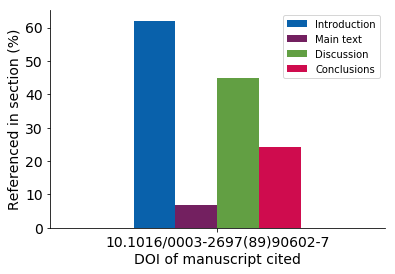

In [23]:
if DOI_cited_list_index in range(len(DOI_list)):


    figure = (
        pd_citation_hist
        .set_index('DOI_cited')
        [['cited_in_introduction', 'cited_in_maintext','cited_in_discussion', 'cited_in_conclusions']]
        .plot(kind='bar', color = ["#0961AB", "#732060", "#629F43", "#CF0C4E"])
    )

    plt.xticks(rotation=0, ha ='center', fontsize=14)
    plt.xlabel("DOI of manuscript cited", fontsize=14)
    plt.yticks(rotation=0, ha ='right', fontsize=14)
    plt.ylabel("Referenced in section (%)", fontsize=14)



    figure.spines["top"].set_visible(False)    
    figure.spines["bottom"].set_visible(True)    
    figure.spines["right"].set_visible(False)    
    figure.spines["left"].set_visible(True)    


    figure.yaxis.set_major_formatter(FuncFormatter(lambda y, _: str(int(y * 100)))) 

    #plt.ylim([0, 1])
    lgd = plt.legend(
        ['Introduction', 'Main text','Discussion', 'Conclusions'],
        #loc='upper right',
        #bbox_to_anchor=(1.013, 1.017),
        #ncol=2
    )

    
    
    
    #plt.figure(figsize = (10,10))
    
    plt.savefig(figure_citation_1DOI, 
                bbox_extra_artists=(lgd,), 
                bbox_inches='tight',
                dpi = 200)
    plt.show()